In [8]:
from DataGeneration import *
import polars as pl
import torch 
import torch.nn as nn
import psutil


from torch.utils.data import TensorDataset,DataLoader,random_split
import time
import multiprocessing as mp



In [9]:
def print_memory_usage():
    process = psutil.Process()
    print(f"Memory usage: {process.memory_info().rss / 1e9:.2f} GB")

In [10]:
a = datagen()
a.apply_simulation()
df = a.retrieve_df()






In [11]:
a.df_to_tensor()
a.standard_normalization()

In [16]:
class RNN(nn.Module):
    def __init__(self, input_len, hidden_size_1, hidden_size_2, out_len):
        super(RNN, self).__init__()


        self.model = nn.Sequential(
            nn.LSTM(input_len, hidden_size_1, batch_first=True),
            nn.LSTM(hidden_size_1, hidden_size_2, batch_first=True),
            nn.Linear(hidden_size_2, out_len)
        )
        
        self._reinitialize()
                
    def _reinitialize(self):
            """
            Tensorflow/Keras-like initialization
            """

            

            for name, p in self.named_parameters():
                if 'lstm' in name:
                    if 'weight_ih' in name:
                        nn.init.xavier_uniform_(p.data)
                    elif 'weight_hh' in name:
                        nn.init.orthogonal_(p.data)
                    elif 'bias_ih' in name:
                        p.data.fill_(0)
                        # Set forget-gate bias to 1
                        n = p.size(0)
                        p.data[(n // 4):(n // 2)].fill_(1)
                    elif 'bias_hh' in name:
                        p.data.fill_(0)
                elif 'fc' in name:
                    if 'weight' in name:
                        nn.init.xavier_uniform_(p.data)
                    elif 'bias' in name:
                        p.data.fill_(0)
                        
            """code stolen from https://www.kaggle.com/code/junkoda/pytorch-lstm-with-tensorflow-like-initialization"""            
        

    
    def forward(self, x):

        h1 = torch.zeros(1, x.size(0), self.model[0].hidden_size).to(x.device)
        c1 = torch.zeros(1, x.size(0), self.model[0].hidden_size).to(x.device)
        h2 = torch.zeros(1, x.size(0), self.model[1].hidden_size).to(x.device)
        c2 = torch.zeros(1, x.size(0), self.model[1].hidden_size).to(x.device)
        

        x, (h1, c1) = self.model[0](x, (h1, c1))
        

        x, (h2, c2) = self.model[1](x, (h2, c2))
        
  
        x = self.model[2](x)  
        
        return x

In [17]:
# class RNN(nn.Module):
#     def __init__(self, input_len, hidden_size_1, hidden_size_2, out_len):
#         super(RNN, self).__init__()
        
#         self.model = nn.Sequential(
#             nn.GRU(input_len, hidden_size_1, batch_first=True),
#             nn.GRU(hidden_size_1, hidden_size_2, batch_first=True),
#             nn.Linear(hidden_size_2, out_len)
#         )

#     self._reinitialize()
                
#     def _reinitialize(self):
#             """
#             Tensorflow/Keras-like initialization
#             """
#             for name, p in self.named_parameters():
#                 if 'lstm' in name:
#                     if 'weight_ih' in name:
#                         nn.init.xavier_uniform_(p.data)
#                     elif 'weight_hh' in name:
#                         nn.init.orthogonal_(p.data)
#                     elif 'bias_ih' in name:
#                         p.data.fill_(0)
#                         # Set forget-gate bias to 1
#                         n = p.size(0)
#                         p.data[(n // 4):(n // 2)].fill_(1)
#                     elif 'bias_hh' in name:
#                         p.data.fill_(0)
#                 elif 'fc' in name:
#                     if 'weight' in name:
#                         nn.init.xavier_uniform_(p.data)
#                     elif 'bias' in name:
#                         p.data.fill_(0)
#           """code stolen from https://www.kaggle.com/code/junkoda/pytorch-lstm-with-tensorflow-like-initialization""" 
    
#     def forward(self, x):
        
#         h1 = torch.zeros(1, x.size(0), self.model[0].hidden_size).to(x.device)
      
#         h2 = torch.zeros(1, x.size(0), self.model[1].hidden_size).to(x.device)
       
        

#         x, _ = self.model[0](x, h1)
        

#         x, _= self.model[1](x, h2)
        
  
#         x = self.model[2](x)  
        
#         return x

In [18]:
torch.set_num_threads(mp.cpu_count())
device = torch.device('mps')

Model = RNN(4,64,32,2)
Model = Model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(Model.parameters(),lr=0.001,eps=1e-7)

In [19]:
display(Model)

RNN(
  (model): Sequential(
    (0): LSTM(4, 64, batch_first=True)
    (1): LSTM(64, 32, batch_first=True)
    (2): Linear(in_features=32, out_features=2, bias=True)
  )
)

In [20]:
for name , param in Model.named_parameters():
    print(name)

model.0.weight_ih_l0
model.0.weight_hh_l0
model.0.bias_ih_l0
model.0.bias_hh_l0
model.1.weight_ih_l0
model.1.weight_hh_l0
model.1.bias_ih_l0
model.1.bias_hh_l0
model.2.weight
model.2.bias


In [21]:
def train(model, dataset, epochs=100, batch_size=256,val_split=0.1):
    
    val_split = val_split
    val_size = int(val_split * len(dataset))
    train_size = len(dataset) - val_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    batch_size = 256
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,num_workers=mp.cpu_count(),
                              pin_memory=True,persistent_workers = True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True,num_workers=mp.cpu_count(),
                            pin_memory=True,persistent_workers = True)
    
    tic = time.perf_counter()
    train_list=[]
    val_list= []
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for batch_X, batch_y in train_loader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)
            optimizer.zero_grad()
            output = model(batch_X)
            loss = criterion(output, batch_y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            
        train_loss /= len(train_loader)
        

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val = X_val.to(device)
                y_val = y_val.to(device)
                output = model(X_val)
                loss = criterion(output, y_val)
                val_loss += loss.item()
                
        val_loss /= len(val_loader)
        # if epoch+1 % 10 == 0:
        toc = time.perf_counter()
        print(f'Epoch: {epoch}, Elapsed: {(toc - tic):.0f} sec')
        tic = time.perf_counter()
        print("Loss for Training on Epoch " + str(epoch) + " is " + str(val_loss))
        val_list.append(val_loss)
        train_list.append(train_loss)
    return train_list,val_list
            #print_memory_usage()

In [22]:

X_train_np= a.X_train_norm.astype(np.float32)
y_train_np= a.y_train_norm.astype(np.float32)
X_train_tensor = torch.from_numpy(X_train_np)
y_train_tensor = torch.from_numpy(y_train_np)
# X_train_tensor = torch.FloatTensor(a.X_train.astype(np.float32))
# y_train_tensor = torch.FloatTensor(a.y_train.astype(np.float32))


In [23]:
dataset = TensorDataset(X_train_tensor, y_train_tensor)

In [24]:
trainloss,valloss=train(Model, dataset, epochs=100, batch_size=256,val_split=0.1)

Epoch: 0, Elapsed: 13 sec
Loss for Training on Epoch 0 is 0.019052008028935502
Epoch: 1, Elapsed: 3 sec
Loss for Training on Epoch 1 is 0.012635447947239434
Epoch: 2, Elapsed: 3 sec
Loss for Training on Epoch 2 is 0.010608918878629251
Epoch: 3, Elapsed: 3 sec
Loss for Training on Epoch 3 is 0.00863389595825639
Epoch: 4, Elapsed: 3 sec
Loss for Training on Epoch 4 is 0.007786957788522597
Epoch: 5, Elapsed: 3 sec
Loss for Training on Epoch 5 is 0.006703993400420855
Epoch: 6, Elapsed: 3 sec
Loss for Training on Epoch 6 is 0.002454197047174805
Epoch: 7, Elapsed: 3 sec
Loss for Training on Epoch 7 is 0.0014295460876180893
Epoch: 8, Elapsed: 3 sec
Loss for Training on Epoch 8 is 0.0010173858835413638
Epoch: 9, Elapsed: 3 sec
Loss for Training on Epoch 9 is 0.0008267039299459646
Epoch: 10, Elapsed: 3 sec
Loss for Training on Epoch 10 is 0.0006760709845736899
Epoch: 11, Elapsed: 3 sec
Loss for Training on Epoch 11 is 0.0006053076336953651
Epoch: 12, Elapsed: 3 sec
Loss for Training on Epoch 12

In [25]:
with torch.no_grad():
    Model.eval()
    y_pred = Model(torch.from_numpy(a.X_test_norm.astype(np.float32)).to(device))
    test_loss = criterion(y_pred, torch.from_numpy(a.y_test_norm.astype(np.float32)).to(device))
    print('test loss is {}'.format(test_loss))

test loss is 1.5596815501339734e-05


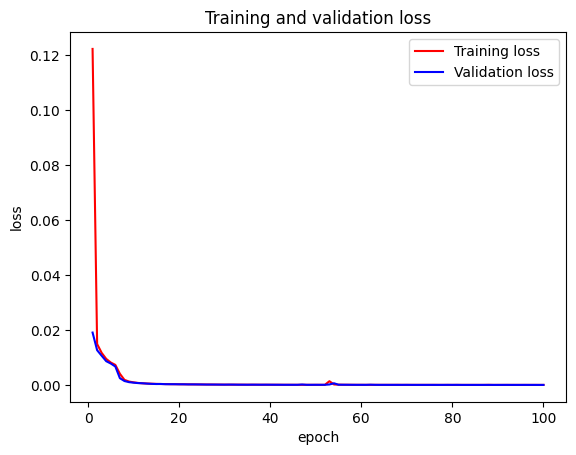

In [26]:
import matplotlib.pyplot as plt

epochs = range(1, len(trainloss) + 1)
plt.plot(epochs, trainloss, 'r', label='Training loss')
plt.plot(epochs, valloss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

In [ ]:
# import tensorflow
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, Activation
# from tensorflow.keras.layers import Embedding
# from tensorflow.keras.preprocessing import sequence
# from tensorflow.keras.initializers import glorot_uniform
# from tensorflow.keras.utils import plot_model
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.losses import MeanSquaredError

# class tensorflow_LSTM:
#     def __init__(self,input_shape,hidden_unit1,hidden_unit2,num_output_variable):

#       self.Input_layer = Input(shape=(None,input_shape), dtype='float32') 
#       x = LSTM(units = hidden_unit1, return_sequences= True)(self.Input_layer)
#       x = LSTM(units = hidden_unit2, return_sequences= True)(x)
#       x = Dense(units = num_output_variable,activation='linear')(x)

#       self.model = Model(inputs= self.Input_layer,outputs=x)
#       # plot_model(self.model, "model.png",show_shapes=True)
      

#     def get_model(self):
#          return self.model

    
    
        

In [ ]:
import tensorflow
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, Activation,GRU
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError

class tensorflow_LSTM:
    def __init__(self,input_shape,hidden_unit1,hidden_unit2,num_output_variable):

      self.Input_layer = Input(shape=(None,input_shape), dtype='float32') 
      x = GRU(units = hidden_unit1, return_sequences= True)(self.Input_layer)
      x = GRU(units = hidden_unit2, return_sequences= True)(x)
      x = Dense(units = num_output_variable,activation='linear')(x)

      self.model = Model(inputs= self.Input_layer,outputs=x)
      # plot_model(self.model, "model.png",show_shapes=True)
      

    def get_model(self):
         return self.model


In [ ]:
model=tensorflow_LSTM(4,64,32,2)
model=model.get_model()
model.compile(
      loss=MeanSquaredError(),
      optimizer=Adam())

history = model.fit(a.X_train_norm, a.y_train_norm, epochs=100, batch_size=256, validation_split=0.1, verbose=2)


In [ ]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

In [ ]:
model.evaluate(a.X_test_norm,a.y_test_norm)

In [ ]:
model.summary()

In [ ]:
# import joblib
# x_scaler = joblib.load('standardscaler/xscaler.pkl')
# y_scaler = joblib.load('standardscaler/yscaler.pkl')




# y = np.linspace(-100, 100, 100000, endpoint=True)

# x_upper = list()
# x_lower = list()
# y_plot = list()

# for i in y:
#     sqrt = np.sqrt(-2688000 * i**2 + 15772800000)
#     if sqrt >= 0:
#         y_plot.append(i)
#         x_upper.append((-4400 * i + sqrt) / 212000)
#         x_lower.append((-4400 * i - sqrt) / 212000)
#         pass
#     pass


# def manual_minmax_inverse(X_scaled, X_min, X_max):
#     return X_scaled * (X_max - X_min) + X_min
    
# plt.figure(figsize=(10,10))

# X_test = torch.from_numpy(a.X_test_norm.astype(np.float32))
# y_test = a.y_test
# X_test = X_test.to(device)

# # plot the first 10 samples and their trajectories
# Model.eval()
# y_predict = Model(X_test).cpu()
# y_predict = y_scaler.inverse_transform(y_predict.detach().numpy().reshape(-1,2)).reshape(-1,10,2)
# #y_test =  y_scaler.inverse_transform(y_test.numpy().reshape(-1,2)).reshape(-1,10,2)
# X_plot =  a.X_test


# for i in range(500):
#     if i == 0:  # only add label to 1 data point
#         plt.plot(X_plot[i, 0, 0], X_plot[i, 0, 1], marker="*", markersize=15,color='orange')
#         plt.plot(y_test[i, :, 0], y_test[i, :, 1], color='cyan', lw=2, label='Test')
#         plt.plot(y_predict[i, :, 0], y_predict[i, :, 1], color='black', lw=2, ls=':', label='Predicted')
#     else:
#         plt.plot(X_plot[i, 0, 0], X_plot[i, 0, 1], marker="*", markersize=15,color='orange')
#         plt.plot(y_test[i, :, 0], y_test[i, :, 1], color='cyan', lw=2)
#         plt.plot(y_predict[i, :, 0], y_predict[i, :, 1], color='black', lw=2, ls=':')

    
# # plot stability region        
# plt.plot(x_lower, y_plot, color='steelblue')
# plt.plot(x_upper, y_plot, color='steelblue')
# plt.ylim([-100, 100])
# plt.xlim([-2, 2])

# plt.xlabel("C_A - C_As")
# plt.ylabel("T - T_s")
# plt.legend()
# plt.show()    

/var/folders/21/j8pd743n579fmcql4fstpcx80000gn/T/ipykernel_34222/3526228500.py:15: RuntimeWarning: invalid value encountered in sqrt
  sqrt = np.sqrt(-2688000 * i**2 + 15772800000)


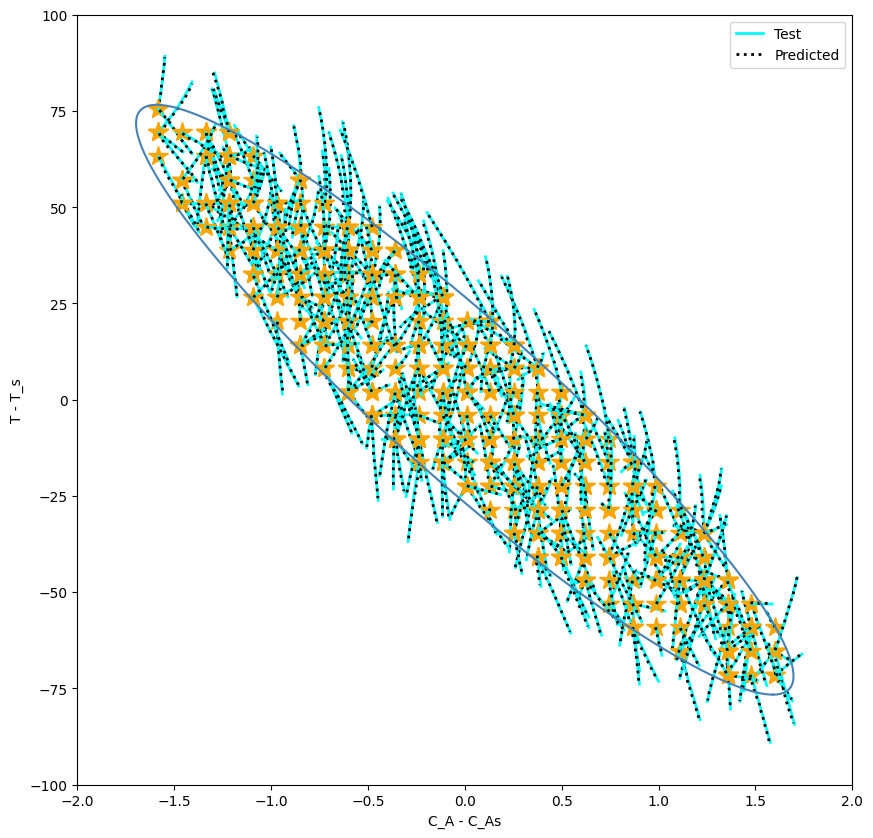

In [27]:
import joblib
x_scaler = joblib.load('standardscaler/xscaler.pkl')
y_scaler = joblib.load('standardscaler/yscaler.pkl')




y = np.linspace(-100, 100, 100000, endpoint=True)

x_upper = list()
x_lower = list()
y_plot = list()

for i in y:
    sqrt = np.sqrt(-2688000 * i**2 + 15772800000)
    if sqrt >= 0:
        y_plot.append(i)
        x_upper.append((-4400 * i + sqrt) / 212000)
        x_lower.append((-4400 * i - sqrt) / 212000)
        pass
    pass


    
plt.figure(figsize=(10,10))

X_test = torch.from_numpy(a.X_test_norm.astype(np.float32))
y_test = a.y_test
X_test = X_test.to(device)

# plot the first 10 samples and their trajectories
Model.eval()
y_predict = Model(X_test).cpu()
y_predict = y_scaler.inverse_transform(y_predict.detach().numpy().reshape(-1,2)).reshape(-1,10,2)
#y_test =  y_scaler.inverse_transform(y_test.numpy().reshape(-1,2)).reshape(-1,10,2)
X_plot =  a.X_test


for i in range(500):
    if i == 0:  # only add label to 1 data point
        plt.plot(X_plot[i, 0, 0], X_plot[i, 0, 1], marker="*", markersize=15,color='orange')
        plt.plot(y_test[i, :, 0], y_test[i, :, 1], color='cyan', lw=2, label='Test')
        plt.plot(y_predict[i, :, 0], y_predict[i, :, 1], color='black', lw=2, ls=':', label='Predicted')
    else:
        plt.plot(X_plot[i, 0, 0], X_plot[i, 0, 1], marker="*", markersize=15,color='orange')
        plt.plot(y_test[i, :, 0], y_test[i, :, 1], color='cyan', lw=2)
        plt.plot(y_predict[i, :, 0], y_predict[i, :, 1], color='black', lw=2, ls=':')

    
# plot stability region        
plt.plot(x_lower, y_plot, color='steelblue')
plt.plot(x_upper, y_plot, color='steelblue')
plt.ylim([-100, 100])
plt.xlim([-2, 2])

plt.xlabel("C_A - C_As")
plt.ylabel("T - T_s")
plt.legend()
plt.show()       